In [1]:
import pandas as pd
from pythainlp.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize
from pythainlp.corpus import thai_stopwords
import numpy as np
import matplotlib.pyplot as plt
import re
import string

In [2]:
chatlog = pd.read_pickle('./data/chatlog.p')

In [3]:
df = chatlog[['userId', 'message', 'role', '_date']] 

In [4]:
# df.drop(df.loc[df.role == "Admin"].index, inplace=True)

In [5]:
df = df.loc[df.role=='User']

In [6]:
df_11_01 = df[df._date == "2019-11-01"]

In [7]:
def get_th_tokens(text):
#     text = text.lower()
    text = text.replace('\n', ' ')
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False)
    return tokens

In [12]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[.?]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]{1,10}', '', text)
    text = re.sub('นะ|น่ะ|น่า|น้า','',text)
    text = re.sub('คะ|ค่ะ|ค่า|คระ|คร่ะ|คร๊|ค๊','',text)
    text = re.sub('ครับ|คับ|คั้บ|ค้าบ|คร้าบ|คาฟ|ค้าฟ|ฮะ|ฮับ|ฮ้าฟ','',text)
    text = re.sub('จ้า|จ้ะ|จ๊ะ','',text)
    text = re.sub('หน่อย|น่อย','',text)
    text = re.sub('สวัสดี|หวัดดี','',text)
    text = re.sub('ของ','',text)
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    text = re.sub(r'<.?>','', text)
    # ลบ hashtag
    text = re.sub(r'#','',text)
    # ลบ separator เช่น \n \t
    text = ' '.join(text.split())
    text = re.sub('สนใจ','',text)
    text = re.sub('อยากทราบว่า|อยากทราบ','',text)
    text = re.sub('รบกวนสอบถาม|ขอสอบถาม|สอบถาม','',text)
    text = re.sub('ปี','',text)
    text = re.sub('ขอบคุณ','',text)
    text = re.sub('ขอโทษ|ขอโทด','',text)
    text = re.sub('ขอ','',text)
    text = re.sub('ชั้น','',text)
    text = re.sub('เท่าไร|เท่าไหร่|เท่าหรั่ย|เท่าใด|เท่ารัย','',text)
    return text

In [13]:
df_11_01['message'] = df_11_01['message'].apply(lambda x: clean_text_round1(x))

/Users/phrare/NTL_dashboard/NTL/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
df_new = df_11_01.groupby(['userId'])['message'].apply(','.join).reset_index()

In [15]:
df_new["message_list"] = df_new["message"].apply(lambda x: x.split())

In [16]:
df_new.head()

,userId,message,message_list
0,1343993022391031,,[]
1,1345416482249396,ยังมีรถขับยุรึป่าวถ้าจะทำ,[ยังมีรถขับยุรึป่าวถ้าจะทำ]
2,1362041543920076,"ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่อ...","[ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่..."
3,1445140482277052,",,งวดยังคงเหลือ กี่งวด,งวดสัญญาเลขที่นี้,งวดยั...","[,,งวดยังคงเหลือ, กี่งวด,งวดสัญญาเลขที่นี้,งวด..."
4,1448022578634827,",ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า แต่ไม่...","[,ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า, แต่ไ..."


In [17]:
vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 

In [18]:
vectorizer.fit(df_new['message']) 

TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x174bde7a0>)

In [19]:
feat = vectorizer.transform(df_new['message']) 
feat_arr = feat.toarray() 

In [20]:
feat_arr.shape

(483, 6091)

In [21]:
avg_tfidf = feat_arr.sum(axis=0) / np.count_nonzero(feat_arr,axis=0) 

In [22]:
result = pd.DataFrame() 
result['word'] = vectorizer.get_feature_names() 
result['avg_tfidf'] = avg_tfidf 

In [23]:
result.sort_values('avg_tfidf', ascending=False).head(10) 

,word,avg_tfidf
2433,บุคคล,1.000000
395,",,,ฟหกหฟก",1.000000
6087,👎🏼😎,1.000000
3059,มี แล้ว,0.836321
3436,"ราคาประเมิน ,",0.736958
3639,วงเงิน คงเหลือ,0.683210
2952,มา กา,0.678719
3064,"มี ใหม,รถยน,",0.672267
5645,"ใหม,รถยน,",0.672267
663,test,0.669207


In [24]:
def filter_words(text):
    text = text.replace('\n', ' ') 
    text = text.replace(',', ' ')
    stop_words = set(thai_stopwords()) 
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False) 
    filtered_text = [] 
    for w in tokens: 
        if w not in stop_words: 
            filtered_text.append(w) 
    return filtered_text

In [25]:
filter_words("ฉันไปเรียนค่ะ")

['เรียน']

In [26]:
df_new["message_filtered"] = df_new["message"].apply(lambda x : filter_words(x)) 

In [27]:
df_new.head()

,userId,message,message_list,message_filtered
0,1343993022391031,,[],[]
1,1345416482249396,ยังมีรถขับยุรึป่าวถ้าจะทำ,[ยังมีรถขับยุรึป่าวถ้าจะทำ],"[ยังมี, รถ, ขับ, ยุ, ป่าว, ทำ]"
2,1362041543920076,"ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่อ...","[ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่...","[เค้า, โทร, แจ้ง, ยอด, โอน, โอน, เงิน, ยอด]"
3,1445140482277052,",,งวดยังคงเหลือ กี่งวด,งวดสัญญาเลขที่นี้,งวดยั...","[,,งวดยังคงเหลือ, กี่งวด,งวดสัญญาเลขที่นี้,งวด...","[งวด, คงเหลือ, กี่, งวด, งวด, สัญญา, เลขที่, ง..."
4,1448022578634827,",ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า แต่ไม่...","[,ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า, แต่ไ...","[เมื่อเดือนที่แล้ว, มอไซค์, เงิน, เต็ม, เต็ม, ..."


In [28]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

In [29]:
df_new['message_filtered'] = df_new['message_filtered'].apply(listToString)

In [30]:
df_new['len_msg'] = df_new['message_filtered'].apply(len)

In [31]:
df_new.head()

,userId,message,message_list,message_filtered,len_msg
0,1343993022391031,,[],,0
1,1345416482249396,ยังมีรถขับยุรึป่าวถ้าจะทำ,[ยังมีรถขับยุรึป่าวถ้าจะทำ],ยังมี รถ ขับ ยุ ป่าว ทำ,23
2,1362041543920076,"ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่อ...","[ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่...",เค้า โทร แจ้ง ยอด โอน โอน เงิน ยอด,34
3,1445140482277052,",,งวดยังคงเหลือ กี่งวด,งวดสัญญาเลขที่นี้,งวดยั...","[,,งวดยังคงเหลือ, กี่งวด,งวดสัญญาเลขที่นี้,งวด...",งวด คงเหลือ กี่ งวด งวด สัญญา เลขที่ งวด คงเหล...,56
4,1448022578634827,",ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า แต่ไม่...","[,ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า, แต่ไ...",เมื่อเดือนที่แล้ว มอไซค์ เงิน เต็ม เต็ม ยอด ไห...,143


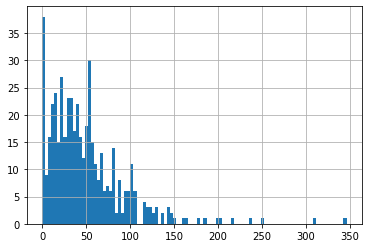

In [32]:
df_new['len_msg'].hist(bins=100)

In [33]:
vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 

In [34]:
vectorizer.fit(df_new['message_filtered']) 

TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x174bde7a0>)

In [35]:
feat_filtered = vectorizer.transform(df_new['message']) 
feat_filtered_arr = feat_filtered.toarray() 

In [36]:
feat_filtered_arr.shape

(483, 4218)

In [37]:
avg_tfidf = feat_filtered_arr.sum(axis=0) / np.count_nonzero(feat_filtered_arr,axis=0) 

/Users/phrare/NTL_dashboard/NTL/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [38]:
result_filtered = pd.DataFrame() 
result_filtered['word'] = vectorizer.get_feature_names() 
result_filtered['avg_tfidf'] = avg_tfidf 

In [39]:
result_filtered.sort_values('avg_tfidf', ascending=False).head(10) 

,word,avg_tfidf
943,ตกงาน,1.000000
2969,ห้,1.000000
1519,บุคคล,1.000000
4208,👎🏼😎,1.000000
175,true,0.916190
2588,วาสนา,0.906449
159,test,0.824861
181,vogo,0.780753
3930,ใจดี,0.778228
1344,นครสวรรค์,0.767285


In [43]:
import re
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [44]:
string = "This is a dinosaur 🦖"

In [45]:
print(remove_emoji(string))

This is a dinosaur 


In [46]:
s1 = "ตลกจัง 😂"

In [47]:
remove_emoji(s1)

'ตลกจัง '

In [48]:
df_new['message_filtered_demoji'] = df_new['message_filtered'].apply(remove_emoji)

In [49]:
df_new.head()

,userId,message,message_list,message_filtered,len_msg,message_filtered_demoji
0,1343993022391031,,[],,0,
1,1345416482249396,ยังมีรถขับยุรึป่าวถ้าจะทำ,[ยังมีรถขับยุรึป่าวถ้าจะทำ],ยังมี รถ ขับ ยุ ป่าว ทำ,23,ยังมี รถ ขับ ยุ ป่าว ทำ
2,1362041543920076,"ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่อ...","[ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่...",เค้า โทร แจ้ง ยอด โอน โอน เงิน ยอด,34,เค้า โทร แจ้ง ยอด โอน โอน เงิน ยอด
3,1445140482277052,",,งวดยังคงเหลือ กี่งวด,งวดสัญญาเลขที่นี้,งวดยั...","[,,งวดยังคงเหลือ, กี่งวด,งวดสัญญาเลขที่นี้,งวด...",งวด คงเหลือ กี่ งวด งวด สัญญา เลขที่ งวด คงเหล...,56,งวด คงเหลือ กี่ งวด งวด สัญญา เลขที่ งวด คงเหล...
4,1448022578634827,",ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า แต่ไม่...","[,ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า, แต่ไ...",เมื่อเดือนที่แล้ว มอไซค์ เงิน เต็ม เต็ม ยอด ไห...,143,เมื่อเดือนที่แล้ว มอไซค์ เงิน เต็ม เต็ม ยอด ไห...


In [50]:
vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 
vectorizer.fit(df_new['message_filtered_demoji']) 

TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x174bde7a0>)

In [51]:
feat_filtered_emoji = vectorizer.transform(df_new['message']) 
feat_filtered_emoji_arr = feat_filtered_emoji.toarray() 

In [52]:
avg_tfidf = feat_filtered_emoji_arr.sum(axis=0) / np.count_nonzero(feat_filtered_emoji_arr,axis=0) 
result_filtered_emoji = pd.DataFrame() 
result_filtered_emoji['word'] = vectorizer.get_feature_names() 
result_filtered_emoji['avg_tfidf'] = avg_tfidf 

/Users/phrare/NTL_dashboard/NTL/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [53]:
result_filtered_emoji.sort_values('avg_tfidf', ascending=False).head(10) 

,word,avg_tfidf
1519,บุคคล,1.000000
2966,ห้,1.000000
943,ตกงาน,1.000000
175,true,0.916190
2587,วาสนา,0.906449
159,test,0.824861
181,vogo,0.780753
3927,ใจดี,0.778228
1344,นครสวรรค์,0.767285
1271,ที่อยู่,0.743045


In [54]:
def remove_digits(text):
    no_digits = []
    # Iterate through the string, adding non-numbers to the no_digits list
    for i in text:
        if not i.isdigit():
            no_digits.append(i)

    # Now join all elements of the list with '', 
    # which puts all of the characters together.
    result = ''.join(no_digits)
    return result

In [55]:
def no_digits(text):
    output = re.sub(r'\d+', '', text)
    return output

In [56]:
s2 = 'แพร 12384975021'

In [57]:
no_digits(s2)

'แพร '

In [58]:
df_new['message_filtered_emo_and_digits'] = df_new['message_filtered_demoji'].apply(no_digits)

In [59]:
df_new.head()

,userId,message,message_list,message_filtered,len_msg,message_filtered_demoji,message_filtered_emo_and_digits
0,1343993022391031,,[],,0,,
1,1345416482249396,ยังมีรถขับยุรึป่าวถ้าจะทำ,[ยังมีรถขับยุรึป่าวถ้าจะทำ],ยังมี รถ ขับ ยุ ป่าว ทำ,23,ยังมี รถ ขับ ยุ ป่าว ทำ,ยังมี รถ ขับ ยุ ป่าว ทำ
2,1362041543920076,"ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่อ...","[ทำไมเค้าโทรแจ้งว่ายอดไม่เข้า,โอนไปตั้งแต่เมื่...",เค้า โทร แจ้ง ยอด โอน โอน เงิน ยอด,34,เค้า โทร แจ้ง ยอด โอน โอน เงิน ยอด,เค้า โทร แจ้ง ยอด โอน โอน เงิน ยอด
3,1445140482277052,",,งวดยังคงเหลือ กี่งวด,งวดสัญญาเลขที่นี้,งวดยั...","[,,งวดยังคงเหลือ, กี่งวด,งวดสัญญาเลขที่นี้,งวด...",งวด คงเหลือ กี่ งวด งวด สัญญา เลขที่ งวด คงเหล...,56,งวด คงเหลือ กี่ งวด งวด สัญญา เลขที่ งวด คงเหล...,งวด คงเหลือ กี่ งวด งวด สัญญา เลขที่ งวด คงเหล...
4,1448022578634827,",ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า แต่ไม่...","[,ถ้าเมื่อเดือนที่แล้วเราเอามอไซค์ไปเข้า, แต่ไ...",เมื่อเดือนที่แล้ว มอไซค์ เงิน เต็ม เต็ม ยอด ไห...,143,เมื่อเดือนที่แล้ว มอไซค์ เงิน เต็ม เต็ม ยอด ไห...,เมื่อเดือนที่แล้ว มอไซค์ เงิน เต็ม เต็ม ยอด ไห...


In [60]:
vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 
vectorizer.fit(df_new['message_filtered_emo_and_digits']) 

TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x174bde7a0>)

In [61]:
feat_filtered_all = vectorizer.transform(df_new['message']) 
feat_filtered_all_arr = feat_filtered_all.toarray() 

In [62]:
avg_tfidf = feat_filtered_all_arr.sum(axis=0) / np.count_nonzero(feat_filtered_all_arr,axis=0) 
result_filtered_all = pd.DataFrame() 
result_filtered_all['word'] = vectorizer.get_feature_names() 
result_filtered_all['avg_tfidf'] = avg_tfidf 

/Users/phrare/NTL_dashboard/NTL/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [63]:
result_filtered_all.sort_values('avg_tfidf', ascending=False).head(10) 

,word,avg_tfidf
1519,บุคคล,1.000000
2966,ห้,1.000000
943,ตกงาน,1.000000
175,true,0.916190
2587,วาสนา,0.906449
159,test,0.824861
181,vogo,0.780753
3927,ใจดี,0.778228
1344,นครสวรรค์,0.767285
1271,ที่อยู่,0.743045


In [64]:
s3 = 'แพร....กินไก่ 3 ตัว 🤪'